# Homework 3 Part 2 Task 1 - Classification
The dataset is from https://www.kaggle.com/c/GiveMeSomeCredit <br>
"Banks play a crucial role in market economies. They decide who can get finance and on what terms and can make or break investment decisions. For markets and society to function, individuals and companies need access to credit. Credit scoring algorithms, which make a guess at the probability of default, are the method banks use to determine whether or not a loan should be granted."  <br>
In this task, we will build classifiers to predict if someone will experience financial distress and therefore cannot pay off credit card (i.e. default). It is a binary classificaiton problem: default (class-1) or not default  (class-0) <br>
Learning Objective: <br>
1. It is almost computationally infeasible to do cross-validation for a large dataset <br>
    So, we divide the data into three sets: training, validation and testing sets <br>
    we do not repeat the above process. 
2. Real dataset is often imbalanced: class-i may have much more data samples than class-j. We set class_weight='balanced' if possible and use weighted classification accuracy, or do upsampling to balance data between classes. 
2. Given the model type (e.g. RandomForest), we find the best trainable-parameters on the training set  <br>
    and find the best hyper-parameters using training-validation strategy <br>
3. Then, we evaluate the trained model on the testing set using the best parameters <br>
4. To simply the task, you only need to find the best max_depth of DecisionTreeClassifier/RandomForestClassifier and the best n_neighbors of KNeighborsClassifier <br>
 <br>
This is a guided-task: <br>
You will see the output of a code cell and then figure out the code in that cell. <br>
In each code cell, there are instructions to help you. <br>
This is a very efficient and effective way to learn how to program with sk-learn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#every row of the table is a data sample (feature vector) from a person
df = pd.read_csv('cs_data.csv')
df.head()

,id,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


#### handle nan (null) in data (i.e. missing values)
Some fields in the table are nan, which are missing values. <br>
For example, someone may not want to reveal monthly income to whoever made the table/survey, then the table got nan.

In [3]:
df.isnull().sum()

id                                          0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [4]:
#here, we use a simple method:
#replace nan in each column with median value of that column
#there are other methods in pandas and sklearn: interpolation in pandas and KNNImputer in sklearn
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
dfv=imputer.fit_transform(df.values)
df=pd.DataFrame(data=dfv, columns=df.columns)
df.isnull().sum()

id                                      0
SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

### We have a highly imbalanced dataset
139974 data samples in class-0 (normal) <br>
10026 data samples in class-1 (financial distress)

<AxesSubplot:>

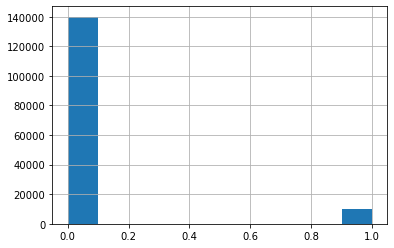

In [5]:
df['SeriousDlqin2yrs'].hist()

In [6]:
(df['SeriousDlqin2yrs']==0).sum()

139974

In [7]:
(df['SeriousDlqin2yrs']==1).sum()

10026

#### Classification Goal: predict 'SeriousDlqin2yrs' (Y) using the other features (X)

In [9]:
#'SeriousDlqin2yrs' is the target/class label, so it should not be in the input feature vector X
#'id' of a person is useless for the classification task
#so, we remove them from the table and get the input X
X=df.drop(['SeriousDlqin2yrs', 'id'], axis=1)
X.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0.766127,45.0,2.0,0.802982,9120.0,13.0,0.0,6.0,0.0,2.0
1,0.957151,40.0,0.0,0.121876,2600.0,4.0,0.0,0.0,0.0,1.0
2,0.658180,38.0,1.0,0.085113,3042.0,2.0,1.0,0.0,0.0,0.0
3,0.233810,30.0,0.0,0.036050,3300.0,5.0,0.0,0.0,0.0,0.0
4,0.907239,49.0,1.0,0.024926,63588.0,7.0,0.0,1.0,0.0,0.0


In [10]:
#Y is the target/class label
Y=df['SeriousDlqin2yrs']
Y.head()

0    1.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: SeriousDlqin2yrs, dtype: float64

In [11]:
# convert pandas dataframe/series to numpy array
# sklearn functions may not work well with pandas data types
X=X.values
Y=Y.values

We split the data into training, validation and testing sets

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
#split X_train and Y_train into a 'pure' training set and a validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=0)
print('train:', X_train.shape, Y_train.shape)
print('validation:', X_val.shape, Y_val.shape)
print('test:', X_test.shape, Y_test.shape)

train: (108000, 10) (108000,)
validation: (12000, 10) (12000,)
test: (30000, 10) (30000,)


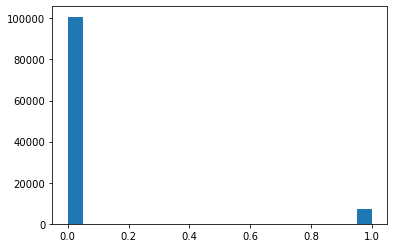

In [13]:
plt.hist(Y_train, bins=20);

In [14]:
(Y_train==0).sum()

100824

In [15]:
(Y_train==1).sum()

7176

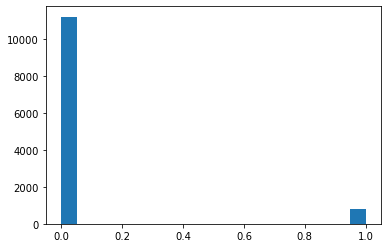

In [16]:
plt.hist(Y_val, bins=20);

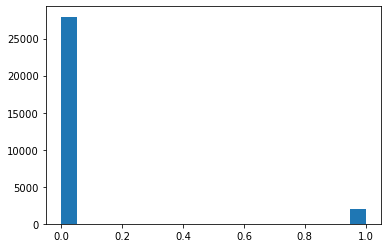

In [17]:
plt.hist(Y_test, bins=20);

In [18]:
# we need to use weighted classification accuracy
# try to understand it
def weighted_accuracy(confusion):
    #input: confusion is the confusion matrix
    #output: acc is the weighted classification accuracy
    M=confusion.copy().astype('float32')
    for k in range(0, M.shape[0]):
        M[k]/=M[k].sum()+1e-8    
    acc = M.diagonal().sum()/M.sum()
    return acc

In [18]:
#apply feature normalization to training, validation and test sets
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(X_train) # only fit to X_train, not X to ensure the testing phase remains truly independent from training
X_train=scaler.transform(X_train)
X_val=scaler.transform(X_val)
X_test=scaler.transform(X_test)

#### build a LogisticRegression classifier as the baseline model

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
#set class_weight='balanced'
LR=LogisticRegression(penalty='none', class_weight='balanced', solver='newton-cg', random_state=0)
LR.fit(X_train, Y_train)
Y_val_pred=LR.predict(X_val)
confusion_val=confusion_matrix(Y_val, Y_val_pred)
acc_val=weighted_accuracy(confusion_val)
Y_test_pred=LR.predict(X_test)
confusion_test=confusion_matrix(Y_test, Y_test_pred)
acc_test=weighted_accuracy(confusion_test)
print('classification accuracy on validation set is ', acc_val)
print('classification accuracy on test set is ', acc_test)

classification accuracy on validation set is  0.7163831
classification accuracy on test set is  0.7099812


## Your task begins here

#### Let's try DecisionTreeClassifier

In [25]:
from sklearn.tree import DecisionTreeClassifier
#set class_weight='balanced', max_depth=20, and random_state=0
#your code here, see the example in the above cell
tree = DecisionTreeClassifier(class_weight='balanced', max_depth=20, random_state=0)
tree.fit(X_train, Y_train)
Y_val_pred = tree.predict(X_val)
confusion_val = confusion_matrix(Y_val, Y_val_pred)
acc_val = weighted_accuracy(confusion_val)

Y_test_pred = tree.predict(X_test)
confusion_test = confusion_matrix(Y_test, Y_test_pred)
acc_test = weighted_accuracy(confusion_test)

#-----------
print('classification accuracy on validation set is ', acc_val)
print('classification accuracy on test set is ', acc_test)

classification accuracy on validation set is  0.6770454
classification accuracy on test set is  0.6608055


#### Let's try randomforest

In [21]:
from sklearn.ensemble import RandomForestClassifier
#set n_estimators=20, class_weight='balanced', max_depth=20, and random_state=0
#your code here
#-----------
print('classification accuracy on validation set is ', acc_val)
print('classification accuracy on test set is ', acc_test)

classification accuracy on validation set is  0.64681727
classification accuracy on test set is  0.63757116


In [27]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=20, class_weight='balanced', max_depth=20, random_state=0)
forest.fit(X_train, Y_train)

Y_val_pred = forest.predict(X_val)
confusion_val = confusion_matrix(Y_val, Y_val_pred)
acc_val = weighted_accuracy(confusion_val)

Y_test_pred = forest.predict(X_test)
confusion_test = confusion_matrix(Y_test, Y_test_pred)
acc_test = weighted_accuracy(confusion_test)

#-----------
print('classification accuracy on validation set is ', acc_val)
print('classification accuracy on test set is ', acc_test)

classification accuracy on validation set is  0.6518632
classification accuracy on test set is  0.6411114


## Model Selection (hyper-parameter optimization) 
Clearly, max_depth=20 is not optimal for DecisionTreeClassifier and RandomForestClassifier <br>
You will do a grid search to find the best max_depth. <br>

### 1. find the best max_depth in DecisionTreeClassifier

In [33]:
#create an array of possible max_depth
# you may need the function np.arange (read the document in sklearn website)
# The minimum value of max_depth is 1, obviously.
# The maximum value of max_depth is 20 (you may use a larger max_depth)
# assume the name of the array is max_depth_list
max_depth_list = np.arange(1,21)
max_depth_list


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

In [38]:
#train a DecisionTreeClassifier with max_depth in max_depth_list
#inside a for loop:
#   create a model with a max_depth in max_depth_list
#   set class_weight to 'balanced'
#   set random_state=0 so that the result is reproducible
#   train the model on the training set
#   record the accuracy on the training set into a list acc_train_list
#   record the accuracy on the validation set into a list acc_val_list
acc_train_list=[]
acc_val_list=[]

for max_depth in max_depth_list:
    tree = DecisionTreeClassifier(class_weight='balanced', max_depth=max_depth, random_state=0)
    tree.fit(X_train, Y_train)
    
    Y_train_pred = tree.predict(X_train)
    confusion_train = confusion_matrix(Y_train, Y_train_pred)
    acc_train = weighted_accuracy(confusion_train)
    acc_train_list.append(acc_train)
    
    Y_val_pred = tree.predict(X_val)
    confusion_val = confusion_matrix(Y_val, Y_val_pred)
    acc_val = weighted_accuracy(confusion_val)
    acc_val_list.append(acc_val)


In [39]:
acc_train_list

[0.73025393,
 0.74848163,
 0.75516665,
 0.761644,
 0.77782166,
 0.7830484,
 0.788645,
 0.79638255,
 0.80346155,
 0.8124621,
 0.823136,
 0.83408487,
 0.8462498,
 0.8599274,
 0.8744754,
 0.89023125,
 0.903829,
 0.9166713,
 0.92975104,
 0.942713]

In [40]:
acc_val_list

[0.7328055,
 0.7472936,
 0.75336516,
 0.76150656,
 0.77176636,
 0.7775296,
 0.7760413,
 0.7702999,
 0.7686645,
 0.7627462,
 0.75887907,
 0.7471343,
 0.73786974,
 0.72655606,
 0.7288303,
 0.7113383,
 0.70090246,
 0.68862927,
 0.6765348,
 0.6770454]

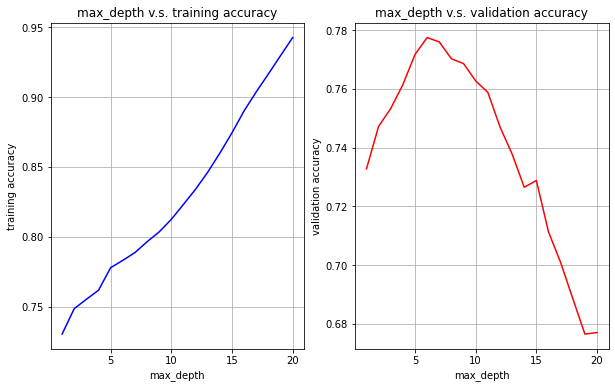

In [43]:
#plot max_depth vs acc_train using max_depth_list and acc_train_list
#plot max_depth vs acc_val using max_depth_list and acc_val_list
fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].plot(max_depth_list, acc_train_list, 'b')
ax[0].set_xlabel('max_depth')
ax[0].set_ylabel('training accuracy')
ax[0].set_title('max_depth v.s. training accuracy')
ax[0].grid(True)
ax[1].plot(max_depth_list, acc_val_list, 'r')
ax[1].set_xlabel('max_depth')
ax[1].set_ylabel('validation accuracy')
ax[1].set_title('max_depth v.s. validation accuracy')
ax[1].grid(True)

From the above figure, we see that training accuracy keeps increasing as max_depth increases. <br>
Validation accuracy reveals the ability of the model predicting y on new data samples that the model did not see during training. <br>
This is why we use validation accuracy curve to find the best hyper-parameter

In [44]:
#write code to find the best max_depth using np.argmax, max_depth_list and acc_val_list
#you may get a different number

max_depth_best = max_depth_list[np.argmax(np.array(acc_val_list))]
max_depth_best

6

In [48]:
#now, we use the max_depth_best to build a DecisionTreeClassifier
#train it on the training set and evaluate it on the testing set
best_tree = DecisionTreeClassifier(class_weight='balanced', max_depth=max_depth_best, random_state=0)
best_tree.fit(X_train, Y_train)

Y_test_pred = best_tree.predict(X_test)
confusion_test = confusion_matrix(Y_test, Y_test_pred)
acc_test = weighted_accuracy(confusion_test)

print('classification accuracy on test set is ', acc_test)

classification accuracy on test set is  0.7604906


In [49]:
confusion_test

array([[20723,  7234],
       [  450,  1593]])

### 2. find the best max_depth in RandomForestClassifier

In [50]:
#create an array of possible max_depth
# you may need the function np.arange
# The minimum value of max_depth is 1, obviously.
# assume the name of the array is max_depth_list
max_depth_list = np.arange(1,21)
max_depth_list

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

In [55]:
#train a RandomForestClassifier with max_depth in max_depth_list
#inside a for loop: 
#   create a model with a max_depth in max_depth_list
#   set class_weight to 'balanced', n_estimators=20
#   set random_state=0 so that the result is reproducible
#   train the model on the training set
#   record the accuracy on the training set into a list acc_train_list
#   record the accuracy on the validation set into a list acc_val_list
acc_train_list=[]
acc_val_list=[]

for max_depth in max_depth_list:
    forest = RandomForestClassifier(n_estimators=20, class_weight='balanced', max_depth=max_depth, random_state=0)
    forest.fit(X_train, Y_train)
    
    Y_train_pred = forest.predict(X_train)
    confusion_train = confusion_matrix(Y_train, Y_train_pred)
    acc_train = weighted_accuracy(confusion_train)
    acc_train_list.append(acc_train)
    
    Y_val_pred = forest.predict(X_val)
    confusion_val = confusion_matrix(Y_val, Y_val_pred)
    acc_val = weighted_accuracy(confusion_val)
    acc_val_list.append(acc_val)
    
print(acc_train_list)
print(acc_val_list)

[0.7528838, 0.75897706, 0.76195526, 0.76883584, 0.77804565, 0.7855084, 0.79213035, 0.79672277, 0.80579424, 0.81316227, 0.82638586, 0.83851147, 0.85187966, 0.86595273, 0.8816892, 0.89849526, 0.9145161, 0.9254457, 0.9425908, 0.95253366]
[0.7581687, 0.76106286, 0.7618596, 0.76771146, 0.77675426, 0.77603555, 0.7834316, 0.7804714, 0.77755976, 0.7772896, 0.77009726, 0.7661873, 0.7475862, 0.734534, 0.7164904, 0.7003617, 0.69370544, 0.6867132, 0.6575055, 0.6518632]


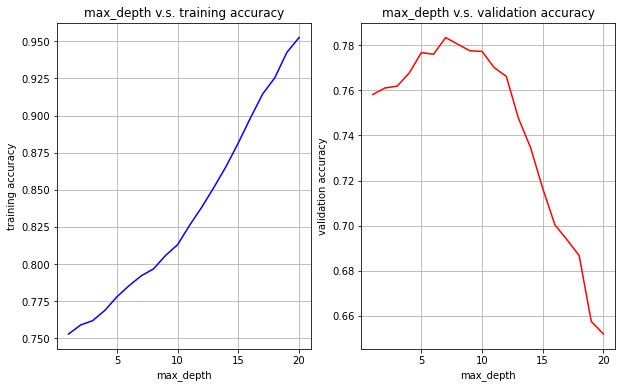

In [56]:
#plot max_depth vs acc_train using max_depth_list and acc_train_list
#plot max_depth vs acc_val using max_depth_list and acc_val_list
fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].plot(max_depth_list, acc_train_list, 'b')
ax[0].set_xlabel('max_depth')
ax[0].set_ylabel('training accuracy')
ax[0].set_title('max_depth v.s. training accuracy')
ax[0].grid(True)
ax[1].plot(max_depth_list, acc_val_list, 'r')
ax[1].set_xlabel('max_depth')
ax[1].set_ylabel('validation accuracy')
ax[1].set_title('max_depth v.s. validation accuracy')
ax[1].grid(True)

In [57]:
##write code to find the best max_depth using np.argmax, max_depth_list and acc_val_list
#you may get a different number
max_depth_best = max_depth_list[np.argmax(np.array(acc_val_list))]
max_depth_best

7

In [59]:
#now, we use the best max_depth to build a RandomForestClassifier
#train it on the training set and evaluate it on the testing set
best_forest = RandomForestClassifier(n_estimators=20, class_weight='balanced', max_depth=max_depth_best, random_state=0)
best_forest.fit(X_train, Y_train)

Y_test_pred = best_forest.predict(X_test)
confusion_test = confusion_matrix(Y_test, Y_test_pred)
acc_test = weighted_accuracy(confusion_test)

print('classification accuracy on testing set is ', acc_test)

classification accuracy on testing set is  0.77304554


In [60]:
confusion_test

array([[21945,  6012],
       [  488,  1555]])

## KNeighborsClassifier and upsampling
We need to find the best hyper-parameter n_neighbors in KNeighborsClassifier <br>
There is no 'class_weight' parameter in KNeighborsClassifier, so we have to do upsampling to handle imbalanced data

In [64]:
# build a KNN Classifier with K=5 on the original dataset (X_train, Y_train)
# test the Classifier on the test set
# get confusion_matrix on the test set
# get weighted_accuracy on the test set
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, Y_train)

Y_test_pred = knn.predict(X_test)
confusion_test = confusion_matrix(Y_test, Y_test_pred)
acc_test = weighted_accuracy(confusion_test)

print('classification accuracy on the testing set is ', acc_test)

classification accuracy on the testing set is  0.5097378


In [92]:
# do up-sampling
# in this new training set, class-0 and clas-1 have equal number of samples (100824)
from sklearn.utils import resample
X_train_c1 = resample(X_train[Y_train==1], n_samples=100824)
Y_train_c1 = np.ones(100824)

# assemble X_train_new, Y_train_new using np.concatenate
X_train_new = np.concatenate((X_train_c1, X_train[Y_train==0]), axis=0)
Y_train_new = np.concatenate((np.ones(100824), np.zeros(100824)))

print("X_train_c1", X_train_c1.shape, Y_train_c1.shape)
print("X_train_new", X_train_new.shape, Y_train_new.shape)


X_train_c1 (100824, 10) (100824,)
X_train_new (201648, 10) (201648,)


In [93]:
# create an array of possible n_neighbors
# name it n_neighbors_list
n_neighbors_list = np.arange(1, 101, 11)
n_neighbors_list

array([  1,  12,  23,  34,  45,  56,  67,  78,  89, 100])

In [94]:
#train a KNeighborsClassifier with n_neighbors in n_neighbors_list
#      using X_train_new, Y_train_new
#inside a for loop: 
#   create a model with a n_neighbors in n_neighbors_list
#   train the model on the new training set (X_train_new, Y_train_new)
#   record the accuracy on the training set into a list acc_train_list
#   record the accuracy on the validation set into a list acc_val_list
#this process is very time-consuming
from sklearn.metrics import accuracy_score

acc_train_list=[]
acc_val_list=[]

for n_neighbors in n_neighbors_list:
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train_new, Y_train_new)

    Y_train_pred = knn.predict(X_train_new)
    acc_train = accuracy_score(Y_train_new, Y_train_pred)
    acc_train_list.append(acc_train)
    
    Y_val_pred = knn.predict(X_val)
    acc_val = accuracy_score(Y_val, Y_val_pred)
    acc_val_list.append(acc_val)
    
print(acc_train_list)
print(acc_val_list)


[0.9992660477664048, 0.8949158930413393, 0.7972605728794732, 0.7469650083313497, 0.7269697691025946, 0.7059231928905816, 0.6912937395858129, 0.6822532333571372, 0.676961834483853, 0.6706587717210188]
[0.8974166666666666, 0.7293333333333333, 0.6240833333333333, 0.68725, 0.6561666666666667, 0.6535833333333333, 0.6499166666666667, 0.6500833333333333, 0.6385, 0.64375]


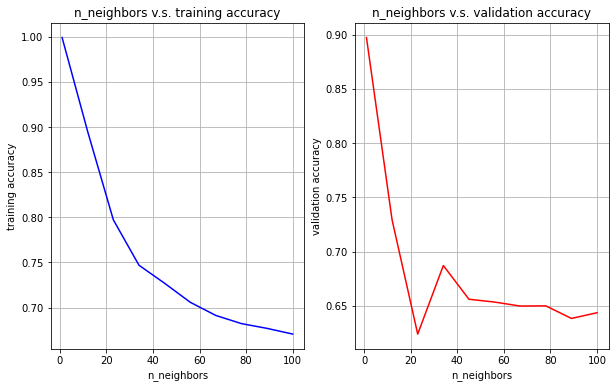

In [96]:
#plot n_neighbors vs acc_train using n_neighbors_list and acc_train_list
#plot n_neighbors vs acc_val using n_neighbors_list and acc_val_list
fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].plot(n_neighbors_list, acc_train_list, 'b')
ax[0].set_xlabel('n_neighbors')
ax[0].set_ylabel('training accuracy')
ax[0].set_title('n_neighbors v.s. training accuracy')
ax[0].grid(True)
ax[1].plot(n_neighbors_list, acc_val_list, 'r')
ax[1].set_xlabel('n_neighbors')
ax[1].set_ylabel('validation accuracy')
ax[1].set_title('n_neighbors v.s. validation accuracy')
ax[1].grid(True)

The trainig accuracy and validation accuracy of KNN keep decreasing as n_neighbors increases. <br>

In [97]:
##write code to find the best n_neighbors using np.argmax, n_neighbors_list and acc_val_list
#you may get a different number
n_neighbors_best = n_neighbors_list[np.argmax(np.array(acc_val_list))]
n_neighbors_best

1

In [99]:
#now, we use n_neighbors_best to build a KNeighborsClassifier
#train it on the new training set and evaluate it on the testing set
best_knn = KNeighborsClassifier(n_neighbors=n_neighbors_best)
best_knn.fit(X_train_new, Y_train_new)

Y_test_pred = best_knn.predict(X_test)
acc_test = accuracy_score(Y_test, Y_test_pred)

print('classification accuracy on testing set is ', acc_test)

classification accuracy on testing set is  0.8972


### Perform grid search for more than one hyper-parameter (you may use a seperate file for this)
We will optimize more than one hyper-parameter of random forest <br>
To simply this sub-task, we will consider only the following hyper-parameters: <br>
`max_depth` <br>
`min_samples_split` <br>
`min_samples_leaf` <br>
`max_features` <br>
`max_samples` <br>
read the template 'basic_steps_classification_cv_hw3.ipynb'  on Blackboard

In [106]:
from sklearn.model_selection import GridSearchCV

max_depth_list = list(np.arange(1, 51, 10))
param_grid = {'max_depth': max_depth_list,
             'min_samples_split': [2, 5], 
             'min_samples_leaf': [1, 2],
             'max_features': ['auto', 'sqrt'],
             'max_samples': [0.8, 0.9]}

gs = GridSearchCV(estimator=RandomForestClassifier(),
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10, n_jobs=-1)
gs.fit(X_train, Y_train)
gs.cv_results_

{'mean_fit_time': array([13.32673612, 13.46531718, 13.75843031, 11.72123103, 13.39091139,
        13.67857914, 14.47614858, 13.42243383, 11.76597741, 11.33131874,
        12.60043159, 14.8709883 , 12.12643402,  9.81830754,  9.4086529 ,
         8.65885596, 23.82695191, 17.52948859, 17.06547606, 14.16987338,
        14.94107287, 14.8094388 , 14.76176784, 14.67799571, 13.68666854,
        13.60017679, 13.73339431, 13.91327016, 14.86959486, 14.8284981 ,
        14.98314915, 14.8754359 , 20.2399374 , 19.94009256, 19.84202747,
        19.92646639, 21.5896215 , 21.53983729, 21.55769267, 21.35246716,
        20.23748374, 20.04959443, 19.97286923, 21.04343553, 21.89896588,
        21.66866612, 21.34161327, 24.53344629, 22.25868747, 22.33316066,
        22.48550539, 22.09618189, 24.06943324, 24.30410244, 23.29476137,
        23.58372362, 22.19457159, 24.2764241 , 21.99355514, 18.07778938,
        17.62351463, 14.38859682, 14.02926133, 13.51450579, 13.51203995,
        12.86346235, 12.64735024, 

In [107]:
gs.best_params_

{'max_depth': 11,
 'max_features': 'auto',
 'max_samples': 0.8,
 'min_samples_leaf': 2,
 'min_samples_split': 5}